In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
df = pd.read_pickle('df_train_api.pk')
df.head()

,groups,type,data,label,coords
270,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[511.0, 143.0, 1217.0, 189.0, 864.0, 166.0]"
271,TAX INVOICE,"(tax invoic, text,text, 2337, 1653)",14754,0,"[717.0, 264.0, 877.0, 284.0, 797.0, 274.0]"
272,ACME VISUAL SYSTEMS,"(acm visual system, text,text,text, 2337, 1653)",14754,0,"[166.0, 351.0, 435.0, 369.0, 300.5, 360.0]"
273,"808, JANTA FLAT, GTB ENCLAVE, NANAD NAGARI","(number janta flat gtb enclav nanad nagari, nu...",14754,0,"[167.0, 384.0, 712.0, 403.0, 439.5, 393.5]"
274,DELHI-110093,"(delhi-110093, text, 2337, 1653)",14754,0,"[168.0, 417.0, 323.0, 436.0, 245.5, 426.5]"


In [3]:
X = df[['groups']]
y = df['label']
df0 = df.query('label==0').sample(frac = 0.1)
df = df[df.label != 0]
df = pd.concat([df, df0], ignore_index=True)

In [4]:
X = df[['groups']]
X.head()

,groups
0,GS-032
1,22/08/2017
2,"Rs16,640"
3,N-10-01/2016-17
4,10-11-2017


In [5]:
y = df['label']
y.value_counts()/y.shape

0     0.632394
18    0.100000
2     0.100000
1     0.097183
14    0.039437
8     0.030986
Name: label, dtype: float64

In [6]:
from keras.preprocessing.text import Tokenizer
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', split=' ', lower=True, )
tokenizer.fit_on_texts(X['groups'].values)

X = tokenizer.texts_to_sequences(X['groups'].values)

# add padding
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=40)

Using TensorFlow backend.


###Applying Pca

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca =PCA(n_components=10)

In [9]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

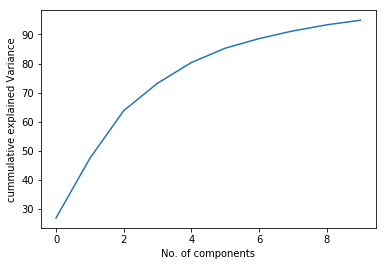

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("No. of components")
plt.ylabel("cummulative explained Variance");

In [11]:
X_pca = pca.transform(X)
X_pca.shape

(710, 10)

### Evaluation Function

In [12]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_score(clf, X_train, X_test, y_train, y_test, train = True):
#     print accuracy score, classification report, confusion metrics
    if train:
#         training performance
        print('Train Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_train, clf.predict(X_train))))
        print('Classification Report : \n {} \n'.format(classification_report(y_train, clf.predict(X_train))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_train, clf.predict(X_train))))
        
        res = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')
        print('Average Accuracy : {0:.4f}\n'.format(np.mean(res)))
        print('Accuracy SD : {0:.4f}\n'.format(np.std(res)))
        
    elif train == False:
#         test performance
        print('Test Result : \n')
        print('Accuracy Score {0:.4f}\n'.format(accuracy_score(y_test, clf.predict(X_test))))
        print('Classification Report : \n {}\n'.format(classification_report(y_test, clf.predict(X_test))))
        print('Confusion Metrics : \n {} \n'.format(confusion_matrix(y_test, clf.predict(X_test))))


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
dt_clf = DecisionTreeClassifier()
params = {'min_samples_split': range(2, 20),
          'min_samples_leaf': range(2, 10),
          'max_depth': [5, 10, 15, 20]}
clf = GridSearchCV(dt_clf, param_grid=params, cv=10)


In [16]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 10, 15, 20], 'min_samples_split': range(2, 20), 'min_samples_leaf': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.8803

Classification Report : 
              precision    recall  f1-score   support

          0       0.94      0.97      0.95       370
          1       0.86      0.96      0.91        57
          2       0.78      0.71      0.74        51
          8       0.55      0.40      0.46        15
         14       0.50      0.38      0.43        21
         18       0.73      0.69      0.70        54

avg / total       0.87      0.88      0.87       568
 

Confusion Metrics : 
 [[358   6   1   1   0   4]
 [  2  55   0   0   0   0]
 [  2   0  36   0   6   7]
 [  5   0   2   6   1   1]
 [  0   3   4   4   8   2]
 [ 13   0   3   0   1  37]] 

Average Accuracy : 0.8296

Accuracy SD : 0.0394

Test Result : 

Accuracy Score 0.7606

Classification Report : 
              precision    recall  f1-score   support

          0       0.84      0.92      0.88        79
          1       0.69      0.92      0.79        12
          2       0.69      0.55      0.61  

In [19]:
clf.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=19,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(n_estimators=300)
bag_clf.fit(X_train, y_train)
print_score(bag_clf, X_train, X_test, y_train, y_test, train = True)
print_score(bag_clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9894

Classification Report : 
              precision    recall  f1-score   support

          0       0.99      0.99      0.99       370
          1       0.98      1.00      0.99        57
          2       1.00      0.98      0.99        51
          8       0.93      0.93      0.93        15
         14       0.95      0.95      0.95        21
         18       0.98      0.98      0.98        54

avg / total       0.99      0.99      0.99       568
 

Confusion Metrics : 
 [[368   1   0   0   0   1]
 [  0  57   0   0   0   0]
 [  1   0  50   0   0   0]
 [  0   0   0  14   1   0]
 [  0   0   0   1  20   0]
 [  1   0   0   0   0  53]] 

Average Accuracy : 0.8611

Accuracy SD : 0.0364

Test Result : 

Accuracy Score 0.8380

Classification Report : 
              precision    recall  f1-score   support

          0       0.90      0.96      0.93        79
          1       0.73      0.92      0.81        12
          2       0.74      0.70      0.72  

In [21]:
from sklearn.ensemble import RandomForestClassifier
params = {'base_estimator': [DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=19, min_samples_leaf=3), RandomForestClassifier()],
          'n_estimators': [100, 200]}

In [22]:
clf = GridSearchCV(bag_clf, param_grid=params, cv=10)

In [23]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200], 'base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_spli...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
clf.best_estimator_

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [26]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9701

Classification Report : 
              precision    recall  f1-score   support

          0       0.98      0.99      0.99       370
          1       0.95      1.00      0.97        57
          2       0.92      0.96      0.94        51
          8       1.00      0.80      0.89        15
         14       0.86      0.90      0.88        21
         18       1.00      0.87      0.93        54

avg / total       0.97      0.97      0.97       568
 

Confusion Metrics : 
 [[367   3   0   0   0   0]
 [  0  57   0   0   0   0]
 [  2   0  49   0   0   0]
 [  0   0   0  12   3   0]
 [  0   0   2   0  19   0]
 [  5   0   2   0   0  47]] 

Average Accuracy : 0.8349

Accuracy SD : 0.0469

Test Result : 

Accuracy Score 0.8028

Classification Report : 
              precision    recall  f1-score   support

          0       0.85      0.95      0.90        79
          1       0.69      0.75      0.72        12
          2       0.76      0.65      0.70  

In [27]:
rf_clf = RandomForestClassifier()
params = {'max_depth': [5, 10, 15],
          'min_samples_split': range(2,10),
          'min_samples_leaf': range(2, 10)}
clf = GridSearchCV(rf_clf, param_grid=params, cv = 10)

In [29]:
clf = GridSearchCV(rf_clf, param_grid=params, cv = 10)
clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(2, 10), 'max_depth': [5, 10, 15], 'min_samples_leaf': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.9137

Classification Report : 
              precision    recall  f1-score   support

          0       0.92      0.99      0.96       370
          1       0.92      0.95      0.93        57
          2       0.88      0.86      0.87        51
          8       1.00      0.13      0.24        15
         14       0.77      0.81      0.79        21
         18       0.95      0.65      0.77        54

avg / total       0.92      0.91      0.90       568
 

Confusion Metrics : 
 [[367   3   0   0   0   0]
 [  2  54   0   0   0   1]
 [  6   0  44   0   1   0]
 [  8   0   1   2   3   1]
 [  2   1   1   0  17   0]
 [ 13   1   4   0   1  35]] 

Average Accuracy : 0.8140

Accuracy SD : 0.0483

Test Result : 

Accuracy Score 0.7535

Classification Report : 
              precision    recall  f1-score   support

          0       0.77      0.96      0.85        79
          1       0.73      0.67      0.70        12
          2       0.73      0.55      0.63  

In [31]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5, min_samples_split=6), learning_rate=4.5, n_estimators=100)

In [36]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=4.5, n_estimators=100, random_state=None)

In [37]:
print_score(clf, X_train, X_test, y_train, y_test, train = True)
print_score(clf, X_train, X_test, y_train, y_test, train = False)

Train Result : 

Accuracy Score 0.8856

Classification Report : 
              precision    recall  f1-score   support

          0       0.93      0.94      0.93       370
          1       0.84      0.74      0.79        57
          2       0.93      0.76      0.84        51
          8       1.00      0.60      0.75        15
         14       0.78      0.86      0.82        21
         18       0.67      0.91      0.77        54

avg / total       0.89      0.89      0.89       568
 

Confusion Metrics : 
 [[346   3   2   0   0  19]
 [ 15  42   0   0   0   0]
 [  3   4  39   0   2   3]
 [  2   0   0   9   3   1]
 [  0   1   1   0  18   1]
 [  5   0   0   0   0  49]] 

Average Accuracy : 0.7909

Accuracy SD : 0.0726

Test Result : 

Accuracy Score 0.6901

Classification Report : 
              precision    recall  f1-score   support

          0       0.81      0.78      0.79        79
          1       0.73      0.67      0.70        12
          2       0.71      0.60      0.65  

In [ ]:
from keras.models import model_from_json
model_json = clf.to_json()
with open("ann first.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
clf.save_weights("model.h5")